# Chapter 7: Data Wrangling (Clean, Transform, Merge, Reshape)
> Much of the programming work in data analysis and modeling is spent on data preparation: loading, cleaning, transforming, and rearranging. Sometimes the way that data
is stored in files or databases is not the way you need it for a data processing application.
Many people choose to do ad hoc processing of data from one form to another using
a general purpose programming, like Python, Perl, R, or Java, or UNIX text processing
tools like sed or awk. Fortunately, pandas along with the Python standard library pro-
vide you with a high-level, flexible, and high-performance set of core manipulations
and algorithms to enable you to wrangle data into the right form without much trouble.
If you identify a type of data manipulation that isn’t anywhere in this book or elsewhere
in the pandas library, feel free to suggest it on the mailing list or GitHub site. Indeed,
much of the design and implementation of pandas has been driven by the needs of real
world applications.

**Overview**:
* Combining and Merging Data Sets
* Reshaping and Pivoting
* Data Transformation
* String Manipulation
* Example: USDA Food Database

# Combining and Merging Data Sets

* **pandas.merge**: connects rows in DataFrames based on one or more keys. This will
be familiar to users of SQL or other relational databases, as it implements database
join operations.
* **pandas.concat** glues or stacks together objects along an axis.
* **combine_first** instance method enables splicing together overlapping data to fill
in missing values in one object with values from another.

## Database-style DataFrame Merges

In [121]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

### **Case 1**: Merge many-to-one: One DataFrame has multiple rows, and one has one row for each value

In [2]:
df1 = DataFrame({
    'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
    'data1': np.arange(7)
    })
df2 = DataFrame({
        'key': ['a', 'b', 'd'], 
        'data2': np.arange(3)
    })

**pd.merge** is able to merge if both DataFrame has at least 1 common columns, it will keep the same value

In [4]:
pd.merge(df1, df2)

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


We can specify which column to jon in by using **on** option

In [5]:
pd.merge(df1, df2, on='key')

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


If the column names are different in each object, you can specify them separately by using **left_on** and **right_on** options:

In [6]:
df3 = DataFrame({
        'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
        'data1': np.arange(7)
    })
df3

,data1,lkey
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,a
6,6,b


In [7]:
df4 = DataFrame({
        'rkey': ['a', 'b', 'd'], 
        'data2': np.arange(3)
    })
df4

,data2,rkey
0,0,a
1,1,b
2,2,d


In [8]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,data1,lkey,data2,rkey
0,0,b,1,b
1,1,b,1,b
2,6,b,1,b
3,2,a,0,a
4,4,a,0,a
5,5,a,0,a


**pd.merge** by default  does an **'inner' join**, then some rows of each DataFrame can be lost. 

If we don't want to lose any data, then we can change option **how** of **pd.merge** from **inner** by default to **outer**

In [9]:
pd.merge(df1, df2, how='outer')

,data1,key,data2
0,0.0,b,1.0
1,1.0,b,1.0
2,6.0,b,1.0
3,2.0,a,0.0
4,4.0,a,0.0
5,5.0,a,0.0
6,3.0,c,NaN
7,NaN,d,2.0


### Case 2: Merge many-to-many
Many-to-many merges have well-defined though not necessarily intuitive behavior.

In [10]:
df1 = DataFrame({
        'key': ['b', 'b', 'a', 'c', 'a', 'b'],
        'data1': range(6)
    })
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [11]:
df2 = DataFrame({
        'key': ['a', 'b', 'a', 'b', 'd'],
        'data2': range(5)
    })
df2

,data2,key
0,0,a
1,1,b
2,2,a
3,3,b
4,4,d


**how='left'**: Keep all data of df1

In [12]:
pd.merge(df1, df2, on='key', how='left')

,data1,key,data2
0,0,b,1.0
1,0,b,3.0
2,1,b,1.0
3,1,b,3.0
4,2,a,0.0
5,2,a,2.0
6,3,c,NaN
7,4,a,0.0
8,4,a,2.0
9,5,b,1.0


In [13]:
pd.merge(df1, df2, on='key', how='inner')

,data1,key,data2
0,0,b,1
1,0,b,3
2,1,b,1
3,1,b,3
4,5,b,1
5,5,b,3
6,2,a,0
7,2,a,2
8,4,a,0
9,4,a,2


Merge with multiple keys:

In [14]:
left = DataFrame({
        'key1': ['foo', 'foo', 'bar'],
        'key2': ['one', 'two', 'one'],
        'lval': [1, 2, 3]
    })
left

,key1,key2,lval
0,foo,one,1
1,foo,two,2
2,bar,one,3


In [15]:
right = DataFrame({
        'key1': ['foo', 'foo', 'bar', 'bar'],
        'key2': ['one', 'one', 'one', 'two'],
        'rval': [4, 5, 6, 7]
    })
right

,key1,key2,rval
0,foo,one,4
1,foo,one,5
2,bar,one,6
3,bar,two,7


In [16]:
pd.merge(left, right, on =['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


To determine which key combinations will appear in the result depending on the choice
of merge method, think of the multiple keys as forming an array of tuples to be used
as a single join key (even though it’s not actually implemented that way).

A last issue to consider in merge operations is the treatment of overlapping column
names. While you can address the overlap manually (see the later section on renaming
axis labels), merge has a suffixes option for specifying strings to append to overlapping
names in the left and right DataFrame objects:

In [17]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [18]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


## Merging on Index

In some cases, the merge key or keys in a DataFrame will be found in its index. In this
case, you can pass left_index=True or right_index=True (or both) to indicate that the
index should be used as the merge key:

In [5]:
left1 = DataFrame({
    'key': ['a', 'b', 'a', 'a', 'b', 'c'],
    'value': range(6)
})
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [8]:
right1 = DataFrame(
        {'group_val': [3.5, 7]}, 
        index=['a', 'b']
    )
right1

,group_val
a,3.5
b,7.0


In [9]:
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


Since the default merge method is to intersect the join keys, you can instead form the
union of them with an outer join:

In [10]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


With herachical index, it is a bit more complicated:

In [12]:
lefth = DataFrame({
    'key1': ['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'], 
    'key2': [2000, 2001, 2002, 2001, 2002],
    'data': np.arange(5.)
})
lefth

,data,key1,key2
0,0.0,Ohio,2000
1,1.0,Ohio,2001
2,2.0,Ohio,2002
3,3.0,Nevada,2001
4,4.0,Nevada,2002


In [14]:
righth = DataFrame(
    np.arange(12).reshape((6,2)), 
    index=[
        ['Nevada', 'Nevada', 'Nevada', 'Ohio', 'Ohio', 'Ohio'],
        [2001, 2000, 2000, 2000, 2001, 2002]
    ],
    columns=['event1', 'event2']
)
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
       2000       4       5
Ohio   2000       6       7
       2001       8       9
       2002      10      11

In [15]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)

,data,key1,key2,event1,event2
0,0.0,Ohio,2000,6,7
1,1.0,Ohio,2001,8,9
2,2.0,Ohio,2002,10,11
3,3.0,Nevada,2001,0,1


Using the indexes of both sides of the merge is also not an issue:

In [16]:
left2 = DataFrame(
    [[1., 2.], [3., 4.], [5., 6.]], 
    index=['a', 'c', 'e'],
    columns=['Ohio', 'Nevada']
)
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [17]:
right2 = DataFrame(
    [[7., 8.], [9., 10.], [11., 12.], [13, 14]],
    index=['b', 'c', 'd', 'e'], 
    columns=['Missouri', 'Alabama']
)
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [18]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


Lastly, for simple index-on-index merges, you can pass a list of DataFrames to join as
an alternative to using the more general **concat** function described below:

In [19]:
another = DataFrame(
    [[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
    index=['a', 'c', 'e', 'f'], 
    columns=['New York', 'Oregon']
)
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [21]:
left2.join([right2, another], how='outer')

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
b,NaN,NaN,7.0,8.0,NaN,NaN
c,3.0,4.0,9.0,10.0,9.0,10.0
d,NaN,NaN,11.0,12.0,NaN,NaN
e,5.0,6.0,13.0,14.0,11.0,12.0
f,NaN,NaN,NaN,NaN,16.0,17.0


## Concatenating Along an Axis

**Numpy.concatenate**

In [2]:
arr = np.arange(10).reshape(5,2)
arr

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [3]:
np.concatenate([arr, arr], axis=1)

array([[0, 1, 0, 1],
       [2, 3, 2, 3],
       [4, 5, 4, 5],
       [6, 7, 6, 7],
       [8, 9, 8, 9]])

**pandas.concat**

In [5]:
s1 = Series([0, 1], index=['a', 'b'])
s2 = Series([2, 3, 4], index=['c', 'd', 'e'])
s3 = Series([5, 6], index=['f', 'g'])

In [17]:
data = pd.concat([s1, s2, s3])
data

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

In [18]:
type(data)

pandas.core.series.Series

Concat by default works along axis=0, we make concat works along **axis=1**

In [14]:
data = pd.concat([s1, s2, s3], axis=1)
data

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In [15]:
type(data)

pandas.core.frame.DataFrame

**join = 'inner'**

In [19]:
s4 = pd.concat([s1 * 5, s3])
s4

a    0
b    5
f    5
g    6
dtype: int64

In [20]:
pd.concat([s1, s4], axis=1)

,0,1
a,0.0,0
b,1.0,5
f,NaN,5
g,NaN,6


In [21]:
pd.concat([s1, s4], axis=1, join='inner')

,0,1
a,0,0
b,1,5


**join_axes**: change the index of the result after concating

In [22]:
pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,5.0
e,NaN,NaN


In [23]:
print s1
print s2
print s3

a    0
b    1
dtype: int64
c    2
d    3
e    4
dtype: int64
f    5
g    6
dtype: int64



One issue is that the concatenated pieces are not identifiable in the result. Suppose
instead you wanted to create a **hierarchical index** on the concatenation axis. To do this,
use the **keys** argument:

In [25]:
result = pd.concat([s1, s2, s3], keys=['one', 'two', 'three'])
result

one    a    0
       b    1
two    c    2
       d    3
       e    4
three  f    5
       g    6
dtype: int64

Work with **hierarchical index**, remember we have **unstack**, and **stack**

In [26]:
result.unstack()

,a,b,c,d,e,f,g
one,0.0,1.0,NaN,NaN,NaN,NaN,NaN
two,NaN,NaN,2.0,3.0,4.0,NaN,NaN
three,NaN,NaN,NaN,NaN,NaN,5.0,6.0


**DataFrame**: We can use **keys** option to group columns of the result after concating

In [28]:
df1 = DataFrame(
    np.arange(6).reshape(3,2), 
    index=['a', 'b', 'c'],
    columns=['one', 'two']
)
df1

,one,two
a,0,1
b,2,3
c,4,5


In [29]:
df2 = DataFrame(
    np.arange(4).reshape(2,2), 
    index=['a', 'c'],
    columns=['three', 'four']
)
df2

,three,four
a,0,1
c,2,3


In [32]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])

level1     level2     
     one two  three four
a      0   1    0.0  1.0
b      2   3    NaN  NaN
c      4   5    2.0  3.0

If we pass a dict instead of a list, then the dict keys will used for the **keys**

In [36]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)


level1     level2     
     one two  three four
a      0   1    0.0  1.0
b      2   3    NaN  NaN
c      4   5    2.0  3.0

There are couple of additional argument to define how the hirarchical index look like:

In [37]:
print df1
print df2

   one  two
a    0    1
b    2    3
c    4    5
   three  four
a      0     1
c      2     3


In [41]:
data = pd.concat(
    [df1, df2], 
    axis=1,
    keys=['level1', 'level2'],
    names=['upper', 'lower']
)
data

upper level1     level2     
lower    one two  three four
a          0   1    0.0  1.0
b          2   3    NaN  NaN
c          4   5    2.0  3.0

In [47]:
data.shape

(3, 4)

A last consideration concerns DataFrames in which the row index is not meaningful in
the context of the analysis. In this case, you can pass **ignore_index=True**

```
ignore_index : boolean, default False
If True, do not use the index values along the concatenation axis. The
    resulting axis will be labeled 0, ..., n - 1. This is useful if you are
    concatenating objects where the concatenation axis does not have
    meaningful indexing information. Note the index values on the other
    axes are still respected in the join.

```

In [50]:
df1 = DataFrame(np.random.randn(3,4), columns=['a', 'b', 'c', 'd'])
df1

,a,b,c,d
0,0.783462,-0.490676,0.764138,0.584226
1,0.696977,-0.218381,-0.174644,1.117995
2,-0.985106,-1.132162,-0.206506,1.199038


In [52]:
df2 = DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])
df2

,b,d,a
0,0.047962,0.681711,-1.876032
1,0.422917,-0.895919,-0.661437


In [59]:
pd.concat([df1, df2], ignore_index=True)

,a,b,c,d
0,0.783462,-0.490676,0.764138,0.584226
1,0.696977,-0.218381,-0.174644,1.117995
2,-0.985106,-1.132162,-0.206506,1.199038
3,-1.876032,0.047962,NaN,0.681711
4,-0.661437,0.422917,NaN,-0.895919


In [62]:
pd.concat([df1, df2], ignore_index=False)

,a,b,c,d
0,0.783462,-0.490676,0.764138,0.584226
1,0.696977,-0.218381,-0.174644,1.117995
2,-0.985106,-1.132162,-0.206506,1.199038
0,-1.876032,0.047962,NaN,0.681711
1,-0.661437,0.422917,NaN,-0.895919


concat function arguments:

| Argument | Description |
|----------|-------------|
| objs | List or dict of pandas objects to be concatenated. The only required argument |
| axis | Axis to concatenate along; defaults to 0 |
| join | One of 'inner', 'outer' , defaulting to 'outer' ; whether to intersection (inner) or union (outer) together indexes along the other axes |
| join_axes | Specific indexes to use for the other n-1 axes instead of performing union/intersection logic |
| keys | Values to associate with objects being concatenated, forming a hierarchical index along the concatenation axis. Can either be a list or array of arbitrary values, an array of tuples, or a list of arrays (if multiple level arrays passed in levels ) |
| levels | Specific indexes to use as hierarchical index level or levels if keys passed |
| names | Names for created hierarchical levels if keys and / or levels passed |
| verify_integrity | Check new axis in concatenated object for duplicates and raise exception if so. By default( False ) allows duplicates |
| ignore_index | Do not preserve indexes along concatenation axis , instead producing a new range(total_length) index |

## Combining Data with Overlap

Another data combination situation can’t be expressed as either a merge or concatenation operation. You may have two datasets whose indexes overlap in full or part.

In Numpy we have **where**, which expressed a vectosized.

In [63]:
a = Series(
    [np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
    index=['f', 'e', 'd', 'c', 'b', 'a']
)
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [64]:
b = Series(
    np.arange(len(a), dtype=np.float64),
    index=['f', 'e', 'd', 'c', 'b', 'a']
)
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    5.0
dtype: float64

In [68]:
b[-1] = np.nan

In [75]:
result = np.where(pd.isnull(a), b, a)
result

array([ 0. ,  2.5,  2. ,  3.5,  4.5,  nan])

Series has a **combine_first** method, which pluses data and serves the first data firstly. 

In [79]:
print b[:-2]
print a[2:]

f    0.0
e    1.0
d    2.0
c    3.0
dtype: float64
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64


In [78]:
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

With DataFrames, **combine_first** naturally does the same thing column by column, so
you can think of it as “patching” missing data in the calling object with data from the
object you pass:

In [85]:
df1 = DataFrame(
    {'a': [1., np.nan, 5., np.nan],
    'b': [np.nan, 2., np.nan, 6.],
    'c': range(2, 18, 4)}
)
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [86]:
df2 = DataFrame(
    {'a': [5., 4., np.nan, 3., 7.],
    'b': [np.nan, 3., 4., 6., 8.]}
)
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [87]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


# Reshaping and Pivoting

There are a number of fundamental operations for rearranging tabular data. These are
alternatingly referred to as reshape or pivot operations.

## Reshaping with Hierarchical Indexing

Hierarchical indexing provides a consistent way to rearrange data in a DataFrame. There are two primary actions:
* stack : this “rotates” or pivots from the columns in the data to the rows
* unstack : this pivots from the rows into the columns

In [90]:
data = DataFrame(
    np.arange(6).reshape((2, 3)),
    index=pd.Index(['Ohio', 'Colorado'], name='state'),
    columns=pd.Index(['one', 'two', 'three'], name='number')
)
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


**stack** method pivots the columns into the rows, producing a Series:

In [97]:
result = data.stack()
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int64

**unstack**: rearrange hiracrchical-indexed Series into DataFrame

In [98]:
result.unstack()

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


**unstack** a different level by passing a level number or name

In [101]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


Missing data while stack and unstack:

In [102]:
s1 = Series([0, 1, 2, 3], index=['a', 'b', 'c', 'd'])
s2 = Series([4, 5, 6], index=['c', 'd', 'e'])
print s1
print s2


a    0
b    1
c    2
d    3
dtype: int64
c    4
d    5
e    6
dtype: int64


In [103]:
data2 = pd.concat([s1, s2], keys=['one', 'two'])

In [104]:
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [105]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


In [106]:
data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

When unstacking in a DataFrame, the level unstacked becomes the lowest level in the
result:

In [107]:
df = DataFrame(
    {'left': result, 'right': result + 5},
    columns=pd.Index(['left', 'right'], name='side')
)
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [108]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

In [109]:
df.unstack('state').stack('side')

state         Ohio  Colorado
number side                 
one    left      0         3
       right     5         8
two    left      1         4
       right     6         9
three  left      2         5
       right     7        10

## Pivoting “long” to “wide” Format

In [117]:
data = pd.read_csv('data/macrodata.csv')
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter, name='date')
data = DataFrame(data.to_records(),
                 columns=pd.Index(['realgdp', 'infl', 'unemp'], name='item'),
                 index=periods.to_timestamp('D', 'end'))
data

item,realgdp,infl,unemp
date,,,
1959-03-31,2710.349,0.00,5.8
1959-06-30,2778.801,2.34,5.1
1959-09-30,2775.488,2.74,5.3
1959-12-31,2785.204,0.27,5.6
1960-03-31,2847.699,2.31,5.2
1960-06-30,2834.390,0.14,5.2
1960-09-30,2839.022,2.70,5.6
1960-12-31,2802.616,1.21,6.3
1961-03-31,2819.264,-0.40,6.8


In [121]:
ldata = data.stack().reset_index().rename(columns={0: 'value'})
ldata

,date,item,value
0,1959-03-31,realgdp,2710.349
1,1959-03-31,infl,0.000
2,1959-03-31,unemp,5.800
3,1959-06-30,realgdp,2778.801
4,1959-06-30,infl,2.340
5,1959-06-30,unemp,5.100
6,1959-09-30,realgdp,2775.488
7,1959-09-30,infl,2.740
8,1959-09-30,unemp,5.300
9,1959-12-31,realgdp,2785.204


In [126]:
pivoted = ldata.pivot('date', 'item', 'value')
pivoted

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2
1960-06-30,0.14,2834.390,5.2
1960-09-30,2.70,2839.022,5.6
1960-12-31,1.21,2802.616,6.3
1961-03-31,-0.40,2819.264,6.8


In [135]:
pivoted = pd.pivot(index=ldata.date, columns=ldata.item, values=ldata.value)
pivoted

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2
1960-06-30,0.14,2834.390,5.2
1960-09-30,2.70,2839.022,5.6
1960-12-31,1.21,2802.616,6.3
1961-03-31,-0.40,2819.264,6.8


In [123]:
ldata['value2'] = np.random.randn(len(ldata))
ldata

,date,item,value,value2
0,1959-03-31,realgdp,2710.349,-1.152426
1,1959-03-31,infl,0.000,-0.641374
2,1959-03-31,unemp,5.800,0.950842
3,1959-06-30,realgdp,2778.801,1.530489
4,1959-06-30,infl,2.340,-2.004584
5,1959-06-30,unemp,5.100,1.030633
6,1959-09-30,realgdp,2775.488,-0.092996
7,1959-09-30,infl,2.740,0.284266
8,1959-09-30,unemp,5.300,0.152270
9,1959-12-31,realgdp,2785.204,-0.482164


In [132]:
ldata.pivot('date', 'item')

value                     value2                    
item        infl    realgdp unemp      infl   realgdp     unemp
date                                                           
1959-03-31  0.00   2710.349   5.8 -0.641374 -1.152426  0.950842
1959-06-30  2.34   2778.801   5.1 -2.004584  1.530489  1.030633
1959-09-30  2.74   2775.488   5.3  0.284266 -0.092996  0.152270
1959-12-31  0.27   2785.204   5.6 -0.157830 -0.482164 -1.460207
1960-03-31  2.31   2847.699   5.2 -0.517712 -0.198393 -0.792393
1960-06-30  0.14   2834.390   5.2 -1.449867 -0.826109  0.931608
1960-09-30  2.70   2839.022   5.6 -0.938948 -0.910962  0.054081
1960-12-31  1.21   2802.616   6.3  0.186313  0.912146 -1.140145
1961-03-31 -0.40   2819.264   6.8  0.038789  0.117678  0.380244
1961-06-30  1.47   2872.005   7.0  1.111937 -1.527005 -0.123788
1961-09-30  0.80   2918.419   6.8  1.213500  0.527127 -0.305496
1961-12-31  0.80   2977.830   6.2 -2.331080  1.156219 -0.200138
1962-03-31  2.26   3031.241   5.6  1.182995 -1.105331  0.652963
1962-06-30  0.13   3064.709   5.5  0.735339 -0.281444  0.637713
1962-09-30  2.11   3093.047   5.6 -0.539111 -1.520043 -0.420447
1962-12-31  0.79   3100.563   5.5 -0.034911  0.795864  0.008587
1963-03-31  0.53   3141.087   5.8 -1.015554  0.257273  0.266295
1963-06-30  2.75   3180.447   5.7 -0.581047  0.239267 -0.508847
1963-09-30  0.78   3240.332   5.5 -0.094810 -0.014621 -0.976476
1963-12-31  2.46   3264.967   5.6  0.750710 -0.103578  0.076066
1964-03-31  0.13   3338.246   5.5 -0.258703 -1.406131 -0.366816
1964-06-30  0.90   3376.587   5.2  0.737318  1.065500  1.075048
1964-09-30  1.29   3422.469   5.0 -0.014094 -0.015139  0.142435
1964-12-31  2.05   3431.957   5.0 -1.583103  0.059200  0.878952
1965-03-31  1.28   3516.251   4.9 -1.550200 -0.646467  0.250099
1965-06-30  2.54   3563.960   4.7  0.210331  1.098654 -1.356420
1965-09-30  0.89   3636.285   4.4  0.252009  1.556031 -0.758937
1965-12-31  2.90   3724.014   4.1  0.172931 -2.063346 -0.345758
1966-03-31  4.99   3815.423   3.9 -0.657414  0.422081 -0.237666
1966-06-30  2.10   3828.124   3.8  0.751663 -0.522034 -0.215722
...          ...        ...   ...       ...       ...       ...
2002-06-30  1.56  11538.770   5.8 -0.864721 -0.444210  1.892885
2002-09-30  2.66  11596.430   5.7  1.147464 -0.078758  1.506595
2002-12-31  3.08  11598.824   5.8 -0.230893  0.227617 -0.408360
2003-03-31  1.31  11645.819   5.9 -1.216959  0.267855 -0.162229
2003-06-30  1.09  11738.706   6.2 -0.560909 -1.434626 -1.592270
2003-09-30  2.60  11935.461   6.1 -0.799473  0.682986  0.502466
2003-12-31  3.02  12042.817   5.8 -0.755027 -0.172435 -0.061895
2004-03-31  2.35  12127.623   5.7 -1.319661  1.162405  0.288329
2004-06-30  3.61  12213.818   5.6 -0.466444 -1.258029  1.555512
2004-09-30  3.58  12303.533   5.4  0.142704  0.946711  1.056124
2004-12-31  2.09  12410.282   5.4 -1.099412  1.504400 -0.539298
2005-03-31  4.15  12534.113   5.3 -0.235788  2.291306  1.693477
2005-06-30  1.85  12587.535   5.1  0.793138  0.379270 -3.030992
2005-09-30  9.14  12683.153   5.0  1.604311  0.002911  0.568301
2005-12-31  0.40  12748.699   4.9  0.023248 -0.027856  1.985243
2006-03-31  2.60  12915.938   4.7  0.470916 -1.140545 -1.332741
2006-06-30  3.97  12962.462   4.7  0.759919  1.521524  1.915121
2006-09-30 -1.58  12965.916   4.7 -1.851363 -0.457912  0.477387
2006-12-31  3.30  13060.679   4.4  0.663461  0.058192 -0.331363
2007-03-31  4.58  13099.901   4.5  1.102696 -0.408925 -1.217991
2007-06-30  2.75  13203.977   4.5 -1.523835 -0.508365  0.432526
2007-09-30  3.45  13321.109   4.7  1.625612  0.078860 -0.826937
2007-12-31  6.38  13391.249   4.8 -0.866354 -1.164287 -0.553987
2008-03-31  2.82  13366.865   4.9  1.004088 -0.202430 -0.192168
2008-06-30  8.53  13415.266   5.4 -0.611272  1.715594 -0.390874
2008-09-30 -3.16  13324.600   6.0  0.452322 -1.452090  0.915001
2008-12-31 -8.79  13141.920   6.9  0.777142 -0.896554 -0.082837
2009-03-31  0.94  12925.410   8.1  1.558766  0.068180 -0.841718
2009-06-30  3.37  12901.504   9.2  1.250616

Note that pivot is just a shortcut for creating a hierarchical index using set_index and
reshaping with unstack :


In [139]:
unstacked = ldata.set_index(['date', 'item']).unstack('item')
unstacked

value                     value2                    
item        infl    realgdp unemp      infl   realgdp     unemp
date                                                           
1959-03-31  0.00   2710.349   5.8 -0.641374 -1.152426  0.950842
1959-06-30  2.34   2778.801   5.1 -2.004584  1.530489  1.030633
1959-09-30  2.74   2775.488   5.3  0.284266 -0.092996  0.152270
1959-12-31  0.27   2785.204   5.6 -0.157830 -0.482164 -1.460207
1960-03-31  2.31   2847.699   5.2 -0.517712 -0.198393 -0.792393
1960-06-30  0.14   2834.390   5.2 -1.449867 -0.826109  0.931608
1960-09-30  2.70   2839.022   5.6 -0.938948 -0.910962  0.054081
1960-12-31  1.21   2802.616   6.3  0.186313  0.912146 -1.140145
1961-03-31 -0.40   2819.264   6.8  0.038789  0.117678  0.380244
1961-06-30  1.47   2872.005   7.0  1.111937 -1.527005 -0.123788
1961-09-30  0.80   2918.419   6.8  1.213500  0.527127 -0.305496
1961-12-31  0.80   2977.830   6.2 -2.331080  1.156219 -0.200138
1962-03-31  2.26   3031.241   5.6  1.182995 -1.105331  0.652963
1962-06-30  0.13   3064.709   5.5  0.735339 -0.281444  0.637713
1962-09-30  2.11   3093.047   5.6 -0.539111 -1.520043 -0.420447
1962-12-31  0.79   3100.563   5.5 -0.034911  0.795864  0.008587
1963-03-31  0.53   3141.087   5.8 -1.015554  0.257273  0.266295
1963-06-30  2.75   3180.447   5.7 -0.581047  0.239267 -0.508847
1963-09-30  0.78   3240.332   5.5 -0.094810 -0.014621 -0.976476
1963-12-31  2.46   3264.967   5.6  0.750710 -0.103578  0.076066
1964-03-31  0.13   3338.246   5.5 -0.258703 -1.406131 -0.366816
1964-06-30  0.90   3376.587   5.2  0.737318  1.065500  1.075048
1964-09-30  1.29   3422.469   5.0 -0.014094 -0.015139  0.142435
1964-12-31  2.05   3431.957   5.0 -1.583103  0.059200  0.878952
1965-03-31  1.28   3516.251   4.9 -1.550200 -0.646467  0.250099
1965-06-30  2.54   3563.960   4.7  0.210331  1.098654 -1.356420
1965-09-30  0.89   3636.285   4.4  0.252009  1.556031 -0.758937
1965-12-31  2.90   3724.014   4.1  0.172931 -2.063346 -0.345758
1966-03-31  4.99   3815.423   3.9 -0.657414  0.422081 -0.237666
1966-06-30  2.10   3828.124   3.8  0.751663 -0.522034 -0.215722
...          ...        ...   ...       ...       ...       ...
2002-06-30  1.56  11538.770   5.8 -0.864721 -0.444210  1.892885
2002-09-30  2.66  11596.430   5.7  1.147464 -0.078758  1.506595
2002-12-31  3.08  11598.824   5.8 -0.230893  0.227617 -0.408360
2003-03-31  1.31  11645.819   5.9 -1.216959  0.267855 -0.162229
2003-06-30  1.09  11738.706   6.2 -0.560909 -1.434626 -1.592270
2003-09-30  2.60  11935.461   6.1 -0.799473  0.682986  0.502466
2003-12-31  3.02  12042.817   5.8 -0.755027 -0.172435 -0.061895
2004-03-31  2.35  12127.623   5.7 -1.319661  1.162405  0.288329
2004-06-30  3.61  12213.818   5.6 -0.466444 -1.258029  1.555512
2004-09-30  3.58  12303.533   5.4  0.142704  0.946711  1.056124
2004-12-31  2.09  12410.282   5.4 -1.099412  1.504400 -0.539298
2005-03-31  4.15  12534.113   5.3 -0.235788  2.291306  1.693477
2005-06-30  1.85  12587.535   5.1  0.793138  0.379270 -3.030992
2005-09-30  9.14  12683.153   5.0  1.604311  0.002911  0.568301
2005-12-31  0.40  12748.699   4.9  0.023248 -0.027856  1.985243
2006-03-31  2.60  12915.938   4.7  0.470916 -1.140545 -1.332741
2006-06-30  3.97  12962.462   4.7  0.759919  1.521524  1.915121
2006-09-30 -1.58  12965.916   4.7 -1.851363 -0.457912  0.477387
2006-12-31  3.30  13060.679   4.4  0.663461  0.058192 -0.331363
2007-03-31  4.58  13099.901   4.5  1.102696 -0.408925 -1.217991
2007-06-30  2.75  13203.977   4.5 -1.523835 -0.508365  0.432526
2007-09-30  3.45  13321.109   4.7  1.625612  0.078860 -0.826937
2007-12-31  6.38  13391.249   4.8 -0.866354 -1.164287 -0.553987
2008-03-31  2.82  13366.865   4.9  1.004088 -0.202430 -0.192168
2008-06-30  8.53  13415.266   5.4 -0.611272  1.715594 -0.390874
2008-09-30 -3.16  13324.600   6.0  0.452322 -1.452090  0.915001
2008-12-31 -8.79  13141.920   6.9  0.777142 -0.896554 -0.082837
2009-03-31  0.94  12925.410   8.1  1.558766  0.068180 -0.841718
2009-06-30  3.37  12901.504   9.2  1.250616

# Data Transformation

Now, we will discover some techniques about **filtering**, **cleaning** and other transformations

## Removing Duplicates

In [2]:
data = DataFrame(
    {'k1': ['one'] * 3 + ['two'] * 4,
    'k2': [1, 1, 2, 3, 3, 4, 4]}
)
data

,k1,k2
0,one,1
1,one,1
2,one,2
3,two,3
4,two,3
5,two,4
6,two,4


The DataFrame method **duplicated** returns a boolean Series indicating whether each
row is a duplicate or not:

In [3]:
data.duplicated()

0    False
1     True
2    False
3    False
4     True
5    False
6     True
dtype: bool

And **drop_duplicates** will returns a DataFrame where **duplicated** is True

In [4]:
data.drop_duplicates()

,k1,k2
0,one,1
2,one,2
3,two,3
5,two,4


We can specify and subset of data to detect dubplicated.

In [5]:
data['v1'] = range(7)

In [6]:
data

,k1,k2,v1
0,one,1,0
1,one,1,1
2,one,2,2
3,two,3,3
4,two,3,4
5,two,4,5
6,two,4,6


In [7]:
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
3,two,3,3


dubplicated by default keep the first value combination, if we pass **keep=last** then the last value will be get.

In [10]:
data.drop_duplicates(['k1', 'k2'], keep='last')

,k1,k2,v1
1,one,1,1
2,one,2,2
4,two,3,4
6,two,4,6


## Transforming Data Using a Function or Mapping

For many data sets, you may wish to perform some transformation based on the values
in an array, Series, or column in a DataFrame. Consider the following hypothetical data
collected about some kinds of meat

In [11]:
data = DataFrame({
    'food': ['bacon', 'pulled pork', 'bacon', 'Pastrami',
    'corned beef', 'Bacon', 'pastrami', 'honey ham',
    'nova lox'],
    'ounces': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]}
)
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


Suppose you wanted to add a column indicating the type of animal that each food came
from. Let’s write down a mapping of each distinct meat type to the kind of animal:

In [12]:
meat_to_animal = {
    'bacon': 'pig',
    'pulled pork': 'pig',
    'pastrami': 'cow',
    'corned beef': 'cow',
    'honey ham': 'pig',
    'nova lox': 'salmon'
}

**map**: Accept a funtion or dict-like object containing a mapping

In [14]:
data['animal'] = data['food'].map(str.lower).map(meat_to_animal)

In [15]:
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


We could also have passed a function that does all the work:

In [16]:
data['food'].map(lambda x: meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

## Replacing Values

Fill missing data with **fillna** is a case of replacement. **replace** has the same purpose with **map** but simplers.

In [17]:
data = Series([1., -999., 2., -999., -1000., 3.])
data

0       1.0
1    -999.0
2       2.0
3    -999.0
4   -1000.0
5       3.0
dtype: float64

In [21]:
data.replace(-999, np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

Or replace multilple values at one time:


In [22]:
data.replace([-999, -1000], np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

Or pass a dict to replace

In [24]:
data.replace({-999: np.nan, -1000: np.nan})

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

## Renaming Axis Indexes

In [25]:
data = DataFrame(
    np.arange(12).reshape((3, 4)),
    index=['Ohio', 'Colorado', 'New York'],
    columns=['one', 'two', 'three', 'four']
)
data

,one,two,three,four
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


Like a Series, the axis indexes have a **map** method:

In [26]:
data.index

Index([u'Ohio', u'Colorado', u'New York'], dtype='object')

In [28]:
data.index = data.index.map(str.upper)
data

,one,two,three,four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [29]:
data.rename(index=str.title, columns=str.upper)

,ONE,TWO,THREE,FOUR
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


## Discretization and Binning

Continuous data is often discretized or otherwised separated into “bins” for analysis.
Suppose you have data about a group of people in a study, and you want to group them
into discrete age buckets:

In [30]:
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

Now suppose we can devide into group of age. 18 to 25, 26 to 35, 35 to 60 and above 60

In [31]:
bins = [18, 25, 35, 60, 100]

In [33]:
cats = pd.cut(ages, bins)
cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, object): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

The object pandas returns is a special **Categorical** object.

In [35]:
cats.categories

Index([u'(18, 25]', u'(25, 35]', u'(35, 60]', u'(60, 100]'], dtype='object')

Then we can count number of people in each group bins by using **value_counts**

In [36]:
pd.value_counts(cats)

(18, 25]     5
(35, 60]     3
(25, 35]     3
(60, 100]    1
dtype: int64

**right=False**: Greater than or equal, and less than

In [38]:
ages

[20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

In [37]:
pd.cut(ages, [18, 26, 36, 61, 100], right=False)

[[18, 26), [18, 26), [18, 26), [26, 36), [18, 26), ..., [26, 36), [61, 100), [36, 61), [36, 61), [26, 36)]
Length: 12
Categories (4, object): [[18, 26) < [26, 36) < [36, 61) < [61, 100)]

We can also pass your own bin names by passing a list or array to the labels option:

In [40]:
group_names = ['Youth', 'YoungAdult', 'MiddleAged', 'Senior']

In [41]:
pd.cut(ages, bins, labels=group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

If you pass cut a integer number of bins instead of explicit bin edges, it will compute
equal-length bins based on the minimum and maximum values in the data. Consider
the case of some uniformly distributed data chopped into fourths

In [42]:
data = np.random.rand(20)
data

array([ 0.73772599,  0.30156688,  0.64054433,  0.31212086,  0.75978626,
        0.32281947,  0.43182209,  0.04080123,  0.41135155,  0.73054779,
        0.6183104 ,  0.55504168,  0.54526445,  0.67290791,  0.33265286,
        0.76575639,  0.00135643,  0.51438387,  0.02152558,  0.75217488])

In [43]:
pd.cut(data, 4, precision=2)

[(0.57, 0.77], (0.19, 0.38], (0.57, 0.77], (0.19, 0.38], (0.57, 0.77], ..., (0.57, 0.77], (0.00059, 0.19], (0.38, 0.57], (0.00059, 0.19], (0.57, 0.77]]
Length: 20
Categories (4, object): [(0.00059, 0.19] < (0.19, 0.38] < (0.38, 0.57] < (0.57, 0.77]]

A closely related function, **qcut** , bins the data based on sample quantiles. Depending
on the distribution of the data, using cut will not usually result in each bin having the
same number of data points. Since qcut uses sample quantiles instead, by definition
you will obtain roughly equal-size bins:

In [48]:
data = np.random.randn(1000)
cats = pd.qcut(data, 4)
cats

[(0.676, 3.0853], (0.676, 3.0853], [-3.21, -0.619], (0.049, 0.676], (-0.619, 0.049], ..., (-0.619, 0.049], (-0.619, 0.049], (0.676, 3.0853], (-0.619, 0.049], (0.676, 3.0853]]
Length: 1000
Categories (4, object): [[-3.21, -0.619] < (-0.619, 0.049] < (0.049, 0.676] < (0.676, 3.0853]]

In [49]:
pd.value_counts(cats)

(0.676, 3.0853]    250
(0.049, 0.676]     250
(-0.619, 0.049]    250
[-3.21, -0.619]    250
dtype: int64

## Detecting and Filtering Outliers

Filtering or transforming outliers is largely a matter of applying array operations

In [50]:
np.random.seed(12345)

In [53]:
data = DataFrame(np.random.randn(1000, 4))
data

,0,1,2,3
0,-1.166530,-0.075264,0.112345,0.166874
1,0.012628,0.815313,-0.732001,0.868791
2,0.149693,0.485218,0.161056,-1.068808
3,1.190359,-1.053204,0.776001,1.311260
4,1.159677,0.477395,-0.004493,0.574631
5,1.094319,0.179143,1.115972,-0.587780
6,-1.907632,-1.605282,-0.833580,-0.964389
7,-0.738076,0.387475,-0.297376,-1.322115
8,1.258306,-1.130313,0.385064,-0.693637
9,0.966616,-0.374624,1.229986,-0.900868


In [54]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.039859,-0.033350,-0.011749,-0.031858
std,1.004647,0.998154,0.987471,1.013590
min,-3.530912,-3.024110,-3.170292,-3.105636
25%,-0.738643,-0.698731,-0.692887,-0.758010
50%,0.011608,-0.016171,0.022570,-0.035527
75%,0.663800,0.605952,0.666451,0.693491
max,2.916153,3.061029,2.623689,3.144389


Suppose you wanted to find value > 3

In [58]:
data[(np.abs(data) > 3).any(1)]

,0,1,2,3
158,0.623798,-0.436479,0.901529,-3.044612
192,0.617561,-1.148738,-3.170292,-1.017073
348,0.813014,-1.202724,-0.286215,-3.105636
360,0.123291,-3.024110,-1.168413,-0.888664
421,-3.530912,-0.576175,-0.750648,0.025443
712,-0.928871,3.061029,-0.297909,0.990886
787,0.836054,-0.780620,0.622791,3.144389


In [63]:
data[np.abs(data) > 3] = np.sign(data) * 3
data

,0,1,2,3
0,-1.166530,-0.075264,0.112345,0.166874
1,0.012628,0.815313,-0.732001,0.868791
2,0.149693,0.485218,0.161056,-1.068808
3,1.190359,-1.053204,0.776001,1.311260
4,1.159677,0.477395,-0.004493,0.574631
5,1.094319,0.179143,1.115972,-0.587780
6,-1.907632,-1.605282,-0.833580,-0.964389
7,-0.738076,0.387475,-0.297376,-1.322115
8,1.258306,-1.130313,0.385064,-0.693637
9,0.966616,-0.374624,1.229986,-0.900868


In [64]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.039328,-0.033386,-0.011579,-0.031852
std,1.002939,0.997895,0.986940,1.012700
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.738643,-0.698731,-0.692887,-0.758010
50%,0.011608,-0.016171,0.022570,-0.035527
75%,0.663800,0.605952,0.666451,0.693491
max,2.916153,3.000000,2.623689,3.000000


## Permutation and Random Sampling

Calling permutation with the length of the axis
you want to permute produces an array of integers indicating the new ordering:

In [69]:
df = DataFrame(np.arange(5 * 4).reshape(5, 4))
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [71]:
sampler = np.random.permutation(50)
sampler

array([26,  7, 24, 37, 45, 16, 18, 38, 49, 43, 33,  2, 46, 14, 20, 27, 39,
       34, 31, 17,  0, 25, 19, 28, 44,  5, 36, 41, 35,  9, 13, 10, 22,  3,
       11, 15,  6, 47, 48, 40, 42, 29, 30, 21, 32,  4, 12, 23,  1,  8])

In [72]:
df.take(np.random.permutation(len(df)))

,0,1,2,3
4,16,17,18,19
1,4,5,6,7
0,0,1,2,3
2,8,9,10,11
3,12,13,14,15


To generate a sample with replacement, the fastest way is to use **np.random.randint** to
draw random integers:

In [75]:
bag = np.array([5, 7, -1, 6, 4])
sampler = np.random.randint(0, len(bag), size=10)
sampler

array([3, 4, 1, 1, 2, 4, 4, 3, 2, 1])

In [76]:
draws = bag.take(sampler)
draws

array([ 6,  4,  7,  7, -1,  4,  4,  6, -1,  7])

# Example: USDA Food Database

The US Department of Agriculture makes available a database of food nutrient infor-
mation. Ashley Williams, an English hacker, has made available a version of this da-
tabase in JSON format (http://ashleyw.co.uk/project/food-nutrient-database). The re-
cords look like this:
```
{
"id": 21441,
"description": "KENTUCKY FRIED CHICKEN, Fried Chicken, EXTRA CRISPY,
Wing, meat and skin with breading",
"tags": ["KFC"],
"manufacturer": "Kentucky Fried Chicken",
"group": "Fast Foods",
"portions": [
{
"amount": 1,
"unit": "wing, with skin",
"grams": 68.0
},
],
"nutrients": [
{
"value": 20.8,
"units": "g",
"description": "Protein",
"group": "Composition"
},
]
}

```

In [79]:
import json
db = json.load(open('data/foods-2011-10-03.json'))
len(db)

6636

In [80]:
type(db)

list

In [82]:
db[0].keys()

[u'portions',
 u'description',
 u'tags',
 u'nutrients',
 u'group',
 u'id',
 u'manufacturer']

In [83]:
db[0]['nutrients'][0]

{u'description': u'Protein',
 u'group': u'Composition',
 u'units': u'g',
 u'value': 25.18}

In [84]:
nutrients = DataFrame(db[0]['nutrients'])

In [85]:
nutrients

,description,group,units,value
0,Protein,Composition,g,25.180
1,Total lipid (fat),Composition,g,29.200
2,"Carbohydrate, by difference",Composition,g,3.060
3,Ash,Other,g,3.280
4,Energy,Energy,kcal,376.000
5,Water,Composition,g,39.280
6,Energy,Energy,kJ,1573.000
7,"Fiber, total dietary",Composition,g,0.000
8,"Calcium, Ca",Elements,mg,673.000
9,"Iron, Fe",Elements,mg,0.640


When converting a list of dicts to a DataFrame, we can specify a list of fields to extract.
We’ll take the food names, group, id, and manufacturer:

In [86]:
info_keys = ['description', 'group', 'id', 'manufacturer']

In [87]:
info = DataFrame(db, columns=info_keys)
info

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,
5,"Cheese, mozzarella, part skim milk, low moisture",Dairy and Egg Products,1029,
6,"Cheese, romano",Dairy and Egg Products,1038,
7,"Cheese, roquefort",Dairy and Egg Products,1039,
8,"Cheese spread, pasteurized process, american, ...",Dairy and Egg Products,1048,
9,"Cream, fluid, half and half",Dairy and Egg Products,1049,


You can see the distribution of food groups with value_counts :

In [88]:
pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Fruits and Fruit Juices              328
Pork Products                        328
Name: group, dtype: int64

Now, to do some analysis on all of the nutrient data, it’s easiest to assemble the nutrients
for each food into a single large table. To do so, we need to take several steps. First, I’ll
convert each list of food nutrients to a DataFrame, add a column for the food id , and
append the DataFrame to a list. Then, these can be concatenated together with concat :

In [89]:
nutrients = []
for rec in db:
    fnuts = DataFrame(rec['nutrients'])
    fnuts['id'] = rec['id']
    nutrients.append(fnuts)
nutrients = pd.concat(nutrients, ignore_index=True)
nutrients

,description,group,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
5,Water,Composition,g,39.280,1008
6,Energy,Energy,kJ,1573.000,1008
7,"Fiber, total dietary",Composition,g,0.000,1008
8,"Calcium, Ca",Elements,mg,673.000,1008
9,"Iron, Fe",Elements,mg,0.640,1008


there are duplicates in this DataFrame, so it makes
things easier to drop them:

In [90]:
nutrients.duplicated().sum()

14179

In [93]:
nutrients = nutrients.drop_duplicates()
nutrients.duplicated().sum()

0

Since 'group' and 'description' is in both DataFrame objects, we can rename them to
make it clear what is what:

In [111]:
col_mapping = {'description' : 'food',
               'group'       : 'fgroup'}
info = info.rename(columns=col_mapping, copy=False)
info

,food,fgroup,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,
5,"Cheese, mozzarella, part skim milk, low moisture",Dairy and Egg Products,1029,
6,"Cheese, romano",Dairy and Egg Products,1038,
7,"Cheese, roquefort",Dairy and Egg Products,1039,
8,"Cheese spread, pasteurized process, american, ...",Dairy and Egg Products,1048,
9,"Cream, fluid, half and half",Dairy and Egg Products,1049,


In [114]:
col_mapping = {'description' : 'nutrient',
               'group' : 'nutgroup'}
nutrients = nutrients.rename(columns=col_mapping, copy=False)
nutrients

,nutrient,nutgroup,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
5,Water,Composition,g,39.280,1008
6,Energy,Energy,kJ,1573.000,1008
7,"Fiber, total dietary",Composition,g,0.000,1008
8,"Calcium, Ca",Elements,mg,673.000,1008
9,"Iron, Fe",Elements,mg,0.640,1008


we’re ready to merge info with nutrients:

In [115]:
ndata = pd.merge(nutrients, info, on='id', how='outer')
ndata

,nutrient,nutgroup,units,value,id,food,fgroup,manufacturer
0,Protein,Composition,g,25.180,1008,"Cheese, caraway",Dairy and Egg Products,
1,Total lipid (fat),Composition,g,29.200,1008,"Cheese, caraway",Dairy and Egg Products,
2,"Carbohydrate, by difference",Composition,g,3.060,1008,"Cheese, caraway",Dairy and Egg Products,
3,Ash,Other,g,3.280,1008,"Cheese, caraway",Dairy and Egg Products,
4,Energy,Energy,kcal,376.000,1008,"Cheese, caraway",Dairy and Egg Products,
5,Water,Composition,g,39.280,1008,"Cheese, caraway",Dairy and Egg Products,
6,Energy,Energy,kJ,1573.000,1008,"Cheese, caraway",Dairy and Egg Products,
7,"Fiber, total dietary",Composition,g,0.000,1008,"Cheese, caraway",Dairy and Egg Products,
8,"Calcium, Ca",Elements,mg,673.000,1008,"Cheese, caraway",Dairy and Egg Products,
9,"Iron, Fe",Elements,mg,0.640,1008,"Cheese, caraway",Dairy and Egg Products,


In [116]:
ndata.ix[30000]

nutrient                                       Glycine
nutgroup                                   Amino Acids
units                                                g
value                                             0.04
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

we could a plot of median values by food
group and nutrient type

In [117]:
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)
result['Zinc, Zn'].sort_values().plot(kind='barh')

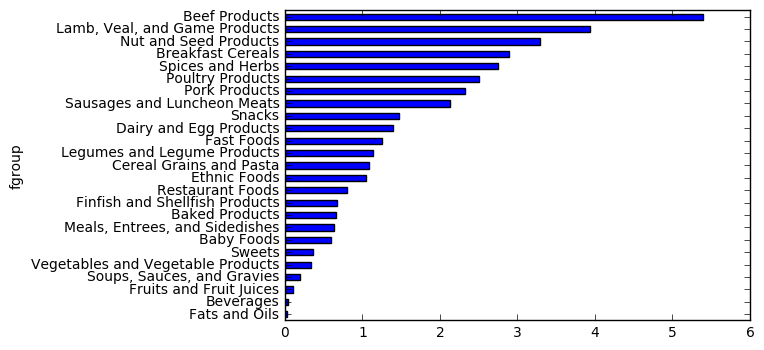

In [118]:
plt.show()

# String Manipulation
Python has long been a popular data munging language in part due to its ease-of-use
for string and text processing. Most text operations are made simple with the string
object’s built-in methods. For more complex pattern matching and text manipulations,
regular expressions may be needed. pandas adds to the mix by enabling you to apply
string and regular expressions concisely on whole arrays of data, additionally handling
the annoyance of missing data.

## String Object Methods

In [122]:
val = 'a,b, guido'

In [124]:
val.split(',')

['a', 'b', ' guido']

**split** is often combined with **strip** to trim whitespace

In [125]:
pieces = [x.strip() for x in val.split(',')]
pieces

['a', 'b', 'guido']

These substrings could be concatenated together with a two-colon delimiter using ad-
dition:

In [126]:
first, second, third = pieces

In [127]:
first + '::' + second + '::' + third

'a::b::guido'

Or using **join**

In [128]:
'::'.join(pieces)

'a::b::guido'

Other methods are concerned with locating substrings. Using Python’s in keyword is
the best way to detect a substring, though index and find can also be used:

In [129]:
'guido' in val

True

In [130]:
val.index(',')

1

In [131]:
val.find(':')

-1

**count** returns the number of occurrences of a particular substring:

In [133]:
val.count(',')

2

**replace** will substitute occurrences of one pattern for another:

In [134]:
val.replace(',', '::')

'a::b:: guido'

## Regular expressions

The **re** module functions fall into three categories: pattern matching, substitution, and
splitting.

In [137]:
import re

In [138]:
text = "foo bar\t baz \tqux"

In [139]:
re.split('\s+', text)

['foo', 'bar', 'baz', 'qux']

or we can create an object of regex then complie later.

In [140]:
regex = re.compile('\s+')

In [141]:
regex.split(text)

['foo', 'bar', 'baz', 'qux']

If, instead, you wanted to get a list of all patterns matching the regex, you can use the
**findall** method:

In [143]:
regex.findall(text)

[' ', '\t ', ' \t']

**search**: Return only first match

In [147]:
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com
"""
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'
# re.IGNORECASE makes the regex case-insensitive
regex = re.compile(pattern, flags=re.IGNORECASE)

In [148]:
regex.findall(text)
['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

In [149]:
m = regex.search(text)

In [150]:
m

In [151]:
text[m.start():m.end()]

'dave@google.com'

**regex.match** return None if the pattern occurded at the start of string:

In [152]:
print regex.match(text)

None


**regex.sub**: sub will return a new string with occurrences of the pattern replaced by the
a new string

In [153]:
print regex.sub('REDACTED', text)

Dave REDACTED
Steve REDACTED
Rob REDACTED
Ryan REDACTED



Suppose you wanted to find email addresses and simultaneously segment each address
into its 3 components: username, domain name, and domain suffix. To do this, put
parentheses around the parts of the pattern to segment:

In [154]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern, flags=re.IGNORECASE)

**regex.groups**

In [155]:
m = regex.match('wesm@bright.net')
m.groups()

('wesm', 'bright', 'net')

**findall** returns a list of tuples when the pattern has groups:

In [156]:
regex.findall(text)

[('dave', 'google', 'com'),
 ('steve', 'gmail', 'com'),
 ('rob', 'gmail', 'com'),
 ('ryan', 'yahoo', 'com')]

sub also has access to groups in each match using special symbols like \1, \2

In [157]:
print regex.sub(r'Username: \1, Domain: \2, Suffix: \3', text)

Dave Username: dave, Domain: google, Suffix: com
Steve Username: steve, Domain: gmail, Suffix: com
Rob Username: rob, Domain: gmail, Suffix: com
Ryan Username: ryan, Domain: yahoo, Suffix: com



## Vectorized string functions in pandas

In [158]:
data = {
    'Dave': 'dave@google.com', 
    'Steve': 'steve@gmail.com',
    'Rob': 'rob@gmail.com', 
    'Wes': np.nan
}
data

{'Dave': 'dave@google.com',
 'Rob': 'rob@gmail.com',
 'Steve': 'steve@gmail.com',
 'Wes': nan}

In [159]:
data = Series(data)

In [160]:
data.isnull()

Dave     False
Rob      False
Steve    False
Wes       True
dtype: bool

String or regular expression can be applied by **map** but it will fail on the NA value. Series provides **str** attribute to skip NA value

In [161]:
data.str.contains('gmail')

Dave     False
Rob       True
Steve     True
Wes        NaN
dtype: object

In [164]:
matches = data.str.findall(pattern, flags=re.IGNORECASE)
matches

Dave     [(dave, google, com)]
Rob        [(rob, gmail, com)]
Steve    [(steve, gmail, com)]
Wes                        NaN
dtype: object

There are a couple of ways to do vectorized element retrieval. Either use **str.get** or
index into the str attribute:

In [165]:
matches.str.get(1)

Dave    NaN
Rob     NaN
Steve   NaN
Wes     NaN
dtype: float64

In [166]:
matches.str[0]

Dave     (dave, google, com)
Rob        (rob, gmail, com)
Steve    (steve, gmail, com)
Wes                      NaN
dtype: object

You can similarly slice strings using this syntax:

In [167]:
data.str[:5]

Dave     dave@
Rob      rob@g
Steve    steve
Wes        NaN
dtype: object